# Scenario Analysis

The objective of this notebook is threefold:

1. To determine an appropriate number of scenarios that capture the full range of possible outcomes (repeating simulation)
2. To analyze the nature of uncertainties within the project and how they affect the outcomes (sensitivity analysis)
3. To identify interesting scenarios to use in direct policy search (scenario discovery)

## 0 Setup

In [3]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## 1 Repeating Simulation within Uncertainty Space

This section aims to determine the appropriate number of scenarios needed to sufficiently cover the uncertainty space. By varying the number of scenarios and running simulations multiple times, we can assess how the distribution of key outcomes changes as the sample size increases. The goal is to identify a scenario count that captures the full range of possible outcomes without excessive computational cost. This ensures robust analysis while maintaining computational efficiency.

### Run simulation

This section runs the simulation experiments. Before executing, ensure you have set the problem formulation (`pf`), number of scenarios (`n_scenario`), number of policies (`n_policy`), and the sampling technique. The code will generate two sets of simulation results for the specified settings. To analyze different scenario counts (as done in this notebook), update the settings and rerun this cell as needed. If you already have the simulation results saved, you can skip this step and proceed directly to the section for loading results from disk.

In [6]:
######## Problem Formulation
pf = 6
n_scenario = 2**6
n_policy = 1
sampling_technique = Samplers.SOBOL

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Reference Policy (No Levers)
ref_policy = [Policy('policy 1', **{'0_RfR 0':0,
                                    '1_RfR 0':0,
                                    '2_RfR 0':0,
                                    '3_RfR 0':0,
                                    '4_RfR 0':0,
                                    '0_RfR 1':0,
                                    '1_RfR 1':0,
                                    '2_RfR 1':0,
                                    '3_RfR 1':0,
                                    '4_RfR 1':0,
                                    'A.1_DikeIncrease 0':0,
                                    'A.2_DikeIncrease 0':0,
                                    'A.3_DikeIncrease 0':0,
                                    'A.4_DikeIncrease 0':0,
                                    'A.5_DikeIncrease 0':0,
                                    'A.1_DikeIncrease 1':0,
                                    'A.2_DikeIncrease 1':0,
                                    'A.3_DikeIncrease 1':0,
                                    'A.4_DikeIncrease 1':0,
                                    'A.5_DikeIncrease 1':0,
                                    'EWS_DaysToThreat':0})
                                ]

######## Run Model
# Run and save results for two different random seeds (suffix 1 and 2)
for suffix in [1, 2]:
    ema_logging.log_to_stderr(ema_logging.INFO)
    with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
        results = evaluator.perform_experiments(scenarios=n_scenario, policies=ref_policy, uncertainty_sampling=sampling_technique)
    save_results(results, f'results/data/GSA_PF{pf}_S{n_scenario}_P{n_policy}_{sampling_technique.name}_{suffix}.tar.gz')

[MainProcess/INFO] pool started with 6 workers
[MainProcess/INFO] performing 2432 scenarios * 1 policies * 1 model(s) = 2432 experiments
100%|██████████████████████████████████████| 2432/2432 [00:48<00:00, 50.52it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S64_P1_SOBOL_1.tar.gz
[MainProcess/INFO] pool started with 6 workers
[MainProcess/INFO] performing 2432 scenarios * 1 policies * 1 model(s) = 2432 experiments
100%|██████████████████████████████████████| 2432/2432 [00:48<00:00, 49.94it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S64_P1_SOBOL_2.tar.gz


### Load run results

In [4]:
# Load Results

# run 1
pf_1 = 6
n_scenario_1 = 2**12
n_policy_1 = 1
sampling_technique_1 = Samplers.SOBOL
suffix_1 = 1
results_1 = load_results(f'results/data/GSA_PF{pf_1}_S{n_scenario_1}_P{n_policy_1}_{sampling_technique_1.name}_{suffix_1}.tar.gz')

# run 2
pf_2= 6
n_scenario_2 = 2**10
n_policy_2 = 1
sampling_technique_2 = Samplers.SOBOL
suffix_2 = 1
results_2 = load_results(f'results/data/GSA_PF{pf_2}_S{n_scenario_2}_P{n_policy_2}_{sampling_technique_2.name}_{suffix_2}.tar.gz')

# run 3
pf_3 = 6
n_scenario_3 = 2**8
n_policy_3 = 1
sampling_technique_3 = Samplers.SOBOL
suffix_3a = 2
results_3a = load_results(f'results/data/GSA_PF{pf_3}_S{n_scenario_3}_P{n_policy_3}_{sampling_technique_3.name}_{suffix_3a}.tar.gz')

# run 3a
pf_3 = 6
n_scenario_3 = 2**8
n_policy_3 = 1
sampling_technique_3 = Samplers.SOBOL
suffix_3 = 2
results_3 = load_results(f'results/data/GSA_PF{pf_3}_S{n_scenario_3}_P{n_policy_3}_{sampling_technique_3.name}_{suffix_3}.tar.gz')

# run 4
pf_4 = 6
n_scenario_4 = 2**6
n_policy_4 = 1
sampling_technique_4 = Samplers.SOBOL
suffix_4 = 2
results_4 = load_results(f'results/data/GSA_PF{pf_4}_S{n_scenario_4}_P{n_policy_4}_{sampling_technique_4.name}_{suffix_4}.tar.gz')

# run 4a
pf_4 = 6
n_scenario_4 = 2**6
n_policy_4 = 1
sampling_technique_4 = Samplers.SOBOL
suffix_4a = 2
results_4a = load_results(f'results/data/GSA_PF{pf_4}_S{n_scenario_4}_P{n_policy_4}_{sampling_technique_4.name}_{suffix_4a}.tar.gz')

# run 5
pf_5 = 6
n_scenario_5 = 2**5
n_policy_5 = 1
sampling_technique_5 = Samplers.SOBOL
suffix_5 = 2
results_5 = load_results(f'results/data/GSA_PF{pf_5}_S{n_scenario_5}_P{n_policy_5}_{sampling_technique_5.name}_{suffix_5}.tar.gz')

# run 6
pf_6 = 6
n_scenario_6 = 2**3
n_policy_6 = 1
sampling_technique_6 = Samplers.SOBOL
suffix_6 = 2
results_6 = load_results(f'results/data/GSA_PF{pf_6}_S{n_scenario_6}_P{n_policy_6}_{sampling_technique_6.name}_{suffix_6}.tar.gz')

experiments_1, outcomes_1 = results_1
experiments_2, outcomes_2 = results_2
experiments_3, outcomes_3 = results_3
experiments_3a, outcomes_3a = results_3a
experiments_4, outcomes_4 = results_4
experiments_4a, outcomes_4a = results_4a
experiments_5, outcomes_5 = results_5
experiments_6, outcomes_6 = results_6

# print shape of experiments and outcomes
print(f'Experiments 1 shape: {experiments_1.shape}')
print(f'Experiments 2 shape: {experiments_2.shape}')
print(f'Experiments 3 shape: {experiments_3.shape}')
print(f'Experiments 3a shape: {experiments_3a.shape}')
print(f'Experiments 4 shape: {experiments_4.shape}')
print(f'Experiments 4a shape: {experiments_4a.shape}')
print(f'Experiments 5 shape: {experiments_5.shape}')
print(f'Experiments 6 shape: {experiments_6.shape}')

[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S4096_P1_SOBOL_1.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S1024_P1_SOBOL_1.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S256_P1_SOBOL_2.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S256_P1_SOBOL_2.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S64_P1_SOBOL_2.tar.gz
[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S64_P1_SOBOL_2

Experiments 1 shape: (155648, 42)
Experiments 2 shape: (38912, 42)
Experiments 3 shape: (9728, 42)
Experiments 3a shape: (9728, 42)
Experiments 4 shape: (2432, 42)
Experiments 4a shape: (2432, 42)
Experiments 5 shape: (1216, 42)
Experiments 6 shape: (304, 42)


### Compare distribution of key outcomes

We visualize the distribution of key outcomes—such as Expected Annual Damage, Expected Number of Deaths, and Total Costs—across multiple simulation runs, each with a different number of scenarios. By plotting histograms for each outcome and dike, we can assess how the shape and spread of the distributions change as the sample size increases. This approach helps us determine the minimum number of scenarios required to reliably capture the full range of possible outcomes, ensuring that our analysis is both robust and computationally efficient.

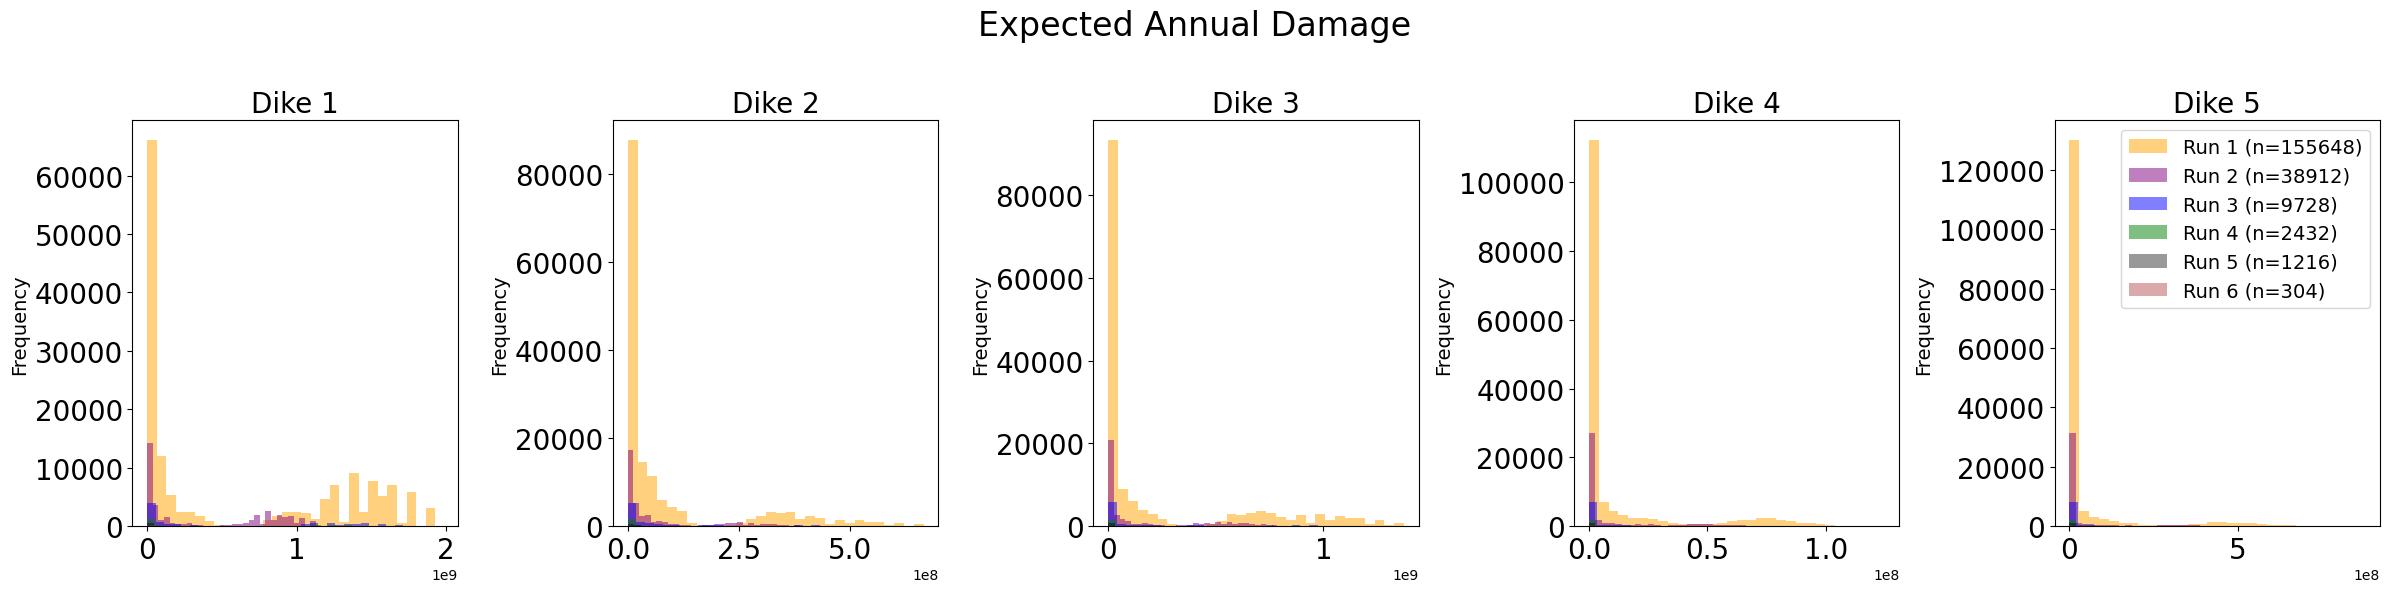

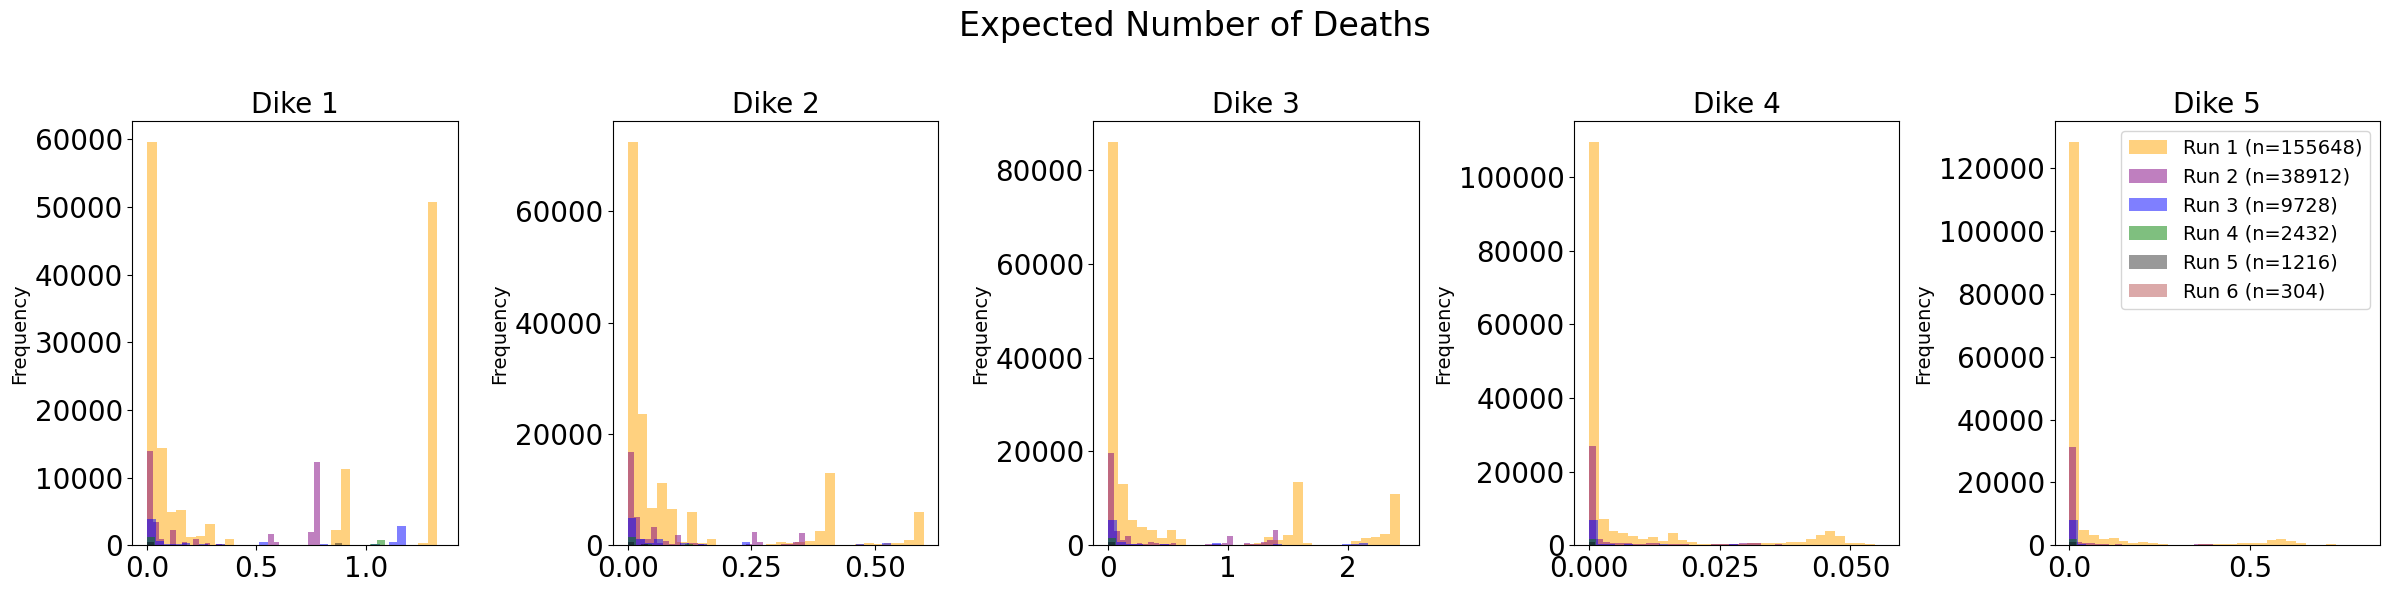

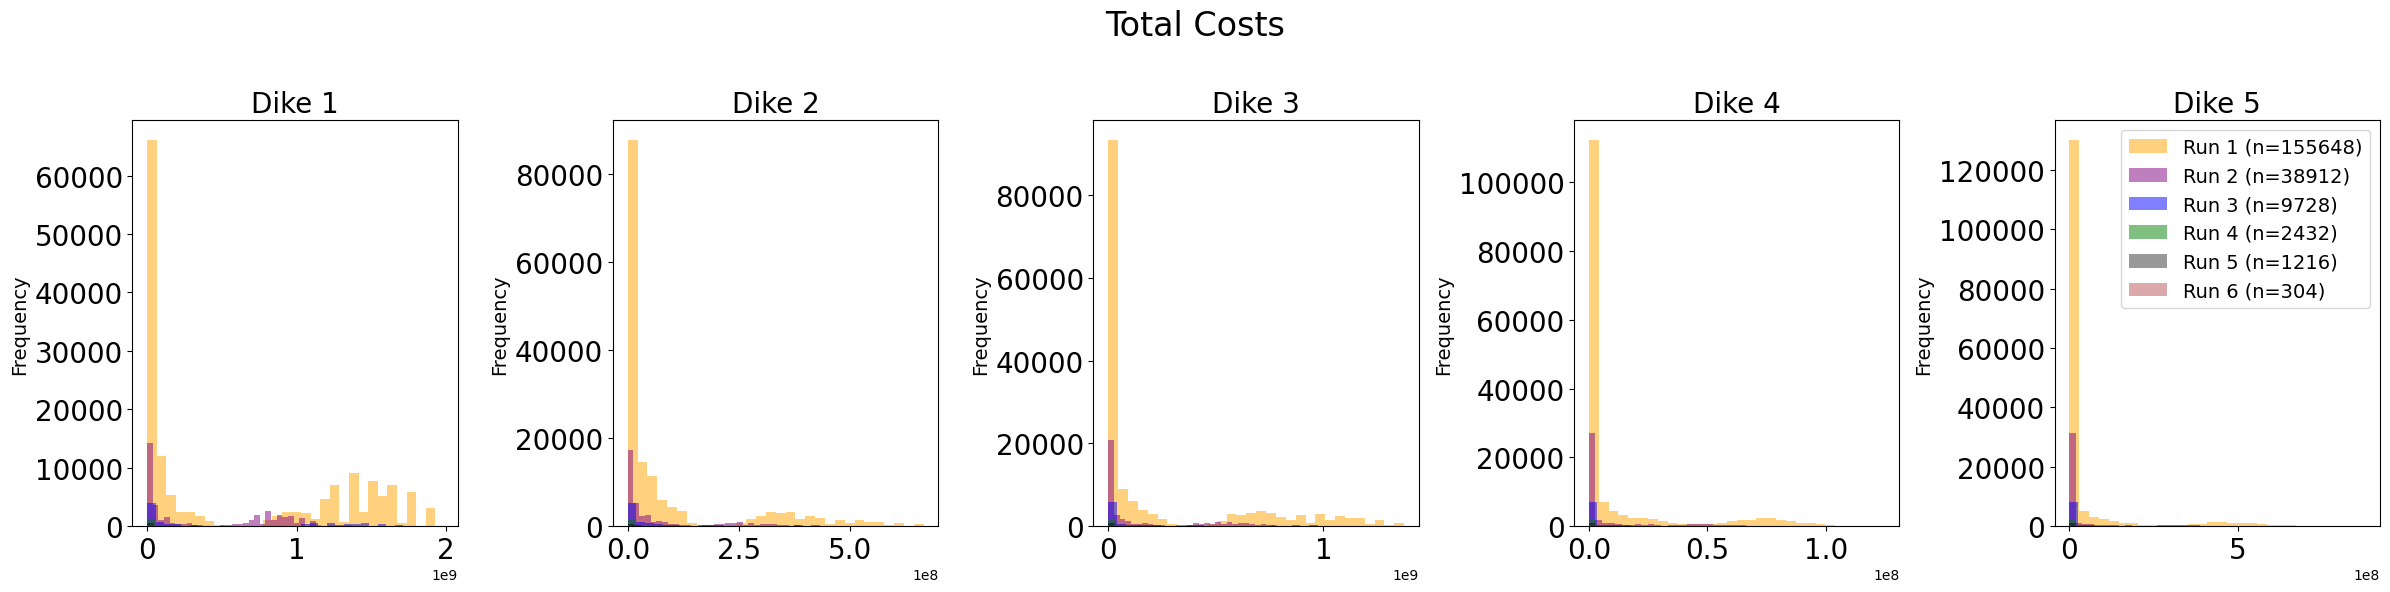

Figure 1: Histograms of disaggregated outcomes for all dikes, comparing 6 runs, in normal scale.


In [24]:
## Histogram plot - normal scale

disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]

# Plot histograms for each disaggregated outcome for all dikes, comparing two runs
for outcome_name in disaggregated_outcome_names:
    fig, axes = plt.subplots(1, 5, figsize=(24, 6))
    for i, dike_no in enumerate(range(1, 6)):
        key = f"A.{dike_no}_{outcome_name}"
        axes[i].hist(outcomes_1[key], bins=30, color='orange', edgecolor='none', alpha=0.5, label=f'Run 1 (n={experiments_1.shape[0]})')
        axes[i].hist(outcomes_2[key], bins=30, color='purple', edgecolor='none', alpha=0.5, label=f'Run 2 (n={experiments_2.shape[0]})')
        axes[i].hist(outcomes_3[key], bins=30, color='blue', edgecolor='none', alpha=0.5, label=f'Run 3 (n={experiments_3.shape[0]})')
        axes[i].hist(outcomes_4[key], bins=30, color='green', edgecolor='none', alpha=0.5, label=f'Run 4 (n={experiments_4.shape[0]})')
        axes[i].hist(outcomes_5[key], bins=30, color='black', edgecolor='none', alpha=0.4, label=f'Run 5 (n={experiments_5.shape[0]})')
        axes[i].hist(outcomes_6[key], bins=30, color='brown', edgecolor='none', alpha=0.4, label=f'Run 6 (n={experiments_6.shape[0]})')
        axes[i].set_title(f"Dike {dike_no}", fontsize=20)
        axes[i].set_ylabel("Frequency", fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=20)
        if i == 4:
            axes[i].legend(fontsize=14)
    fig.suptitle(f"{outcome_name}", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Figure 1: Histograms of disaggregated outcomes for all dikes, comparing 6 runs, in normal scale.")

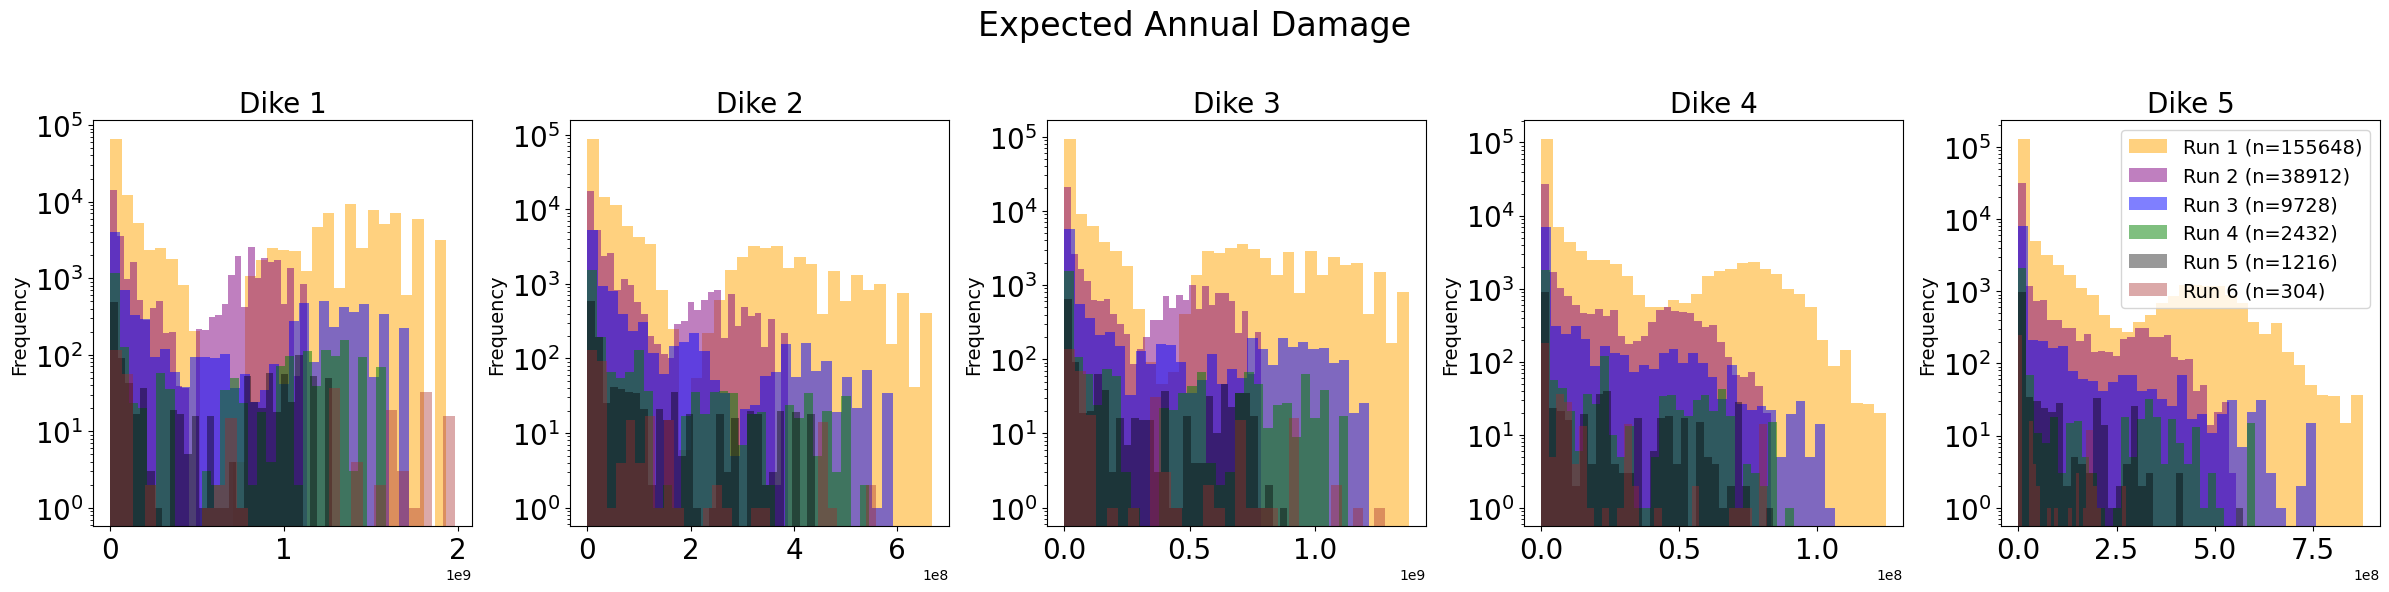

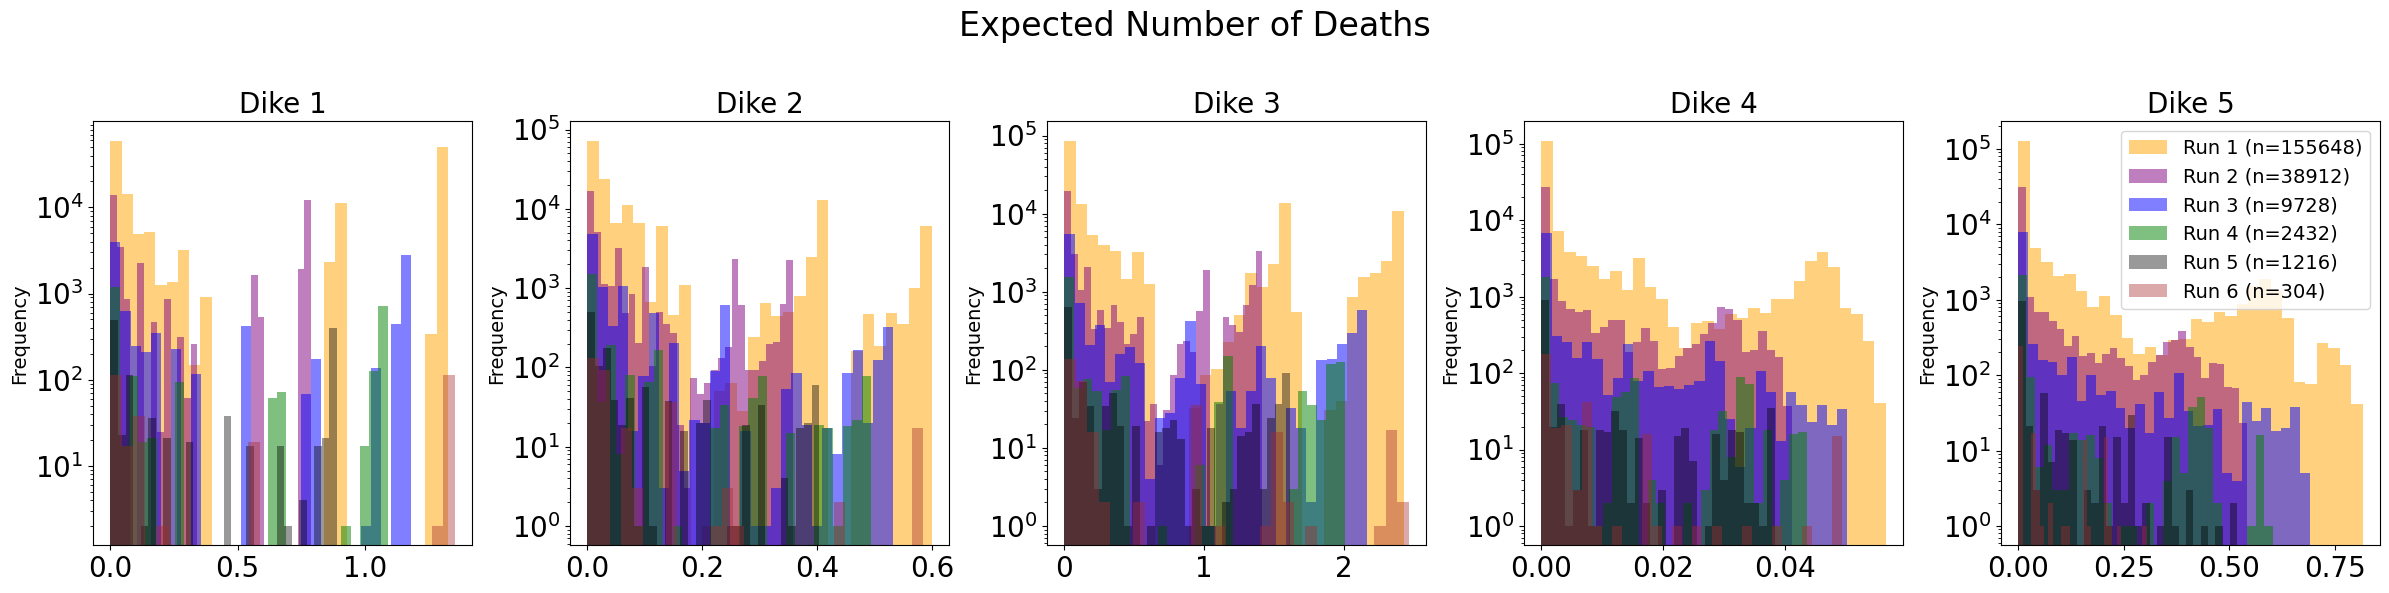

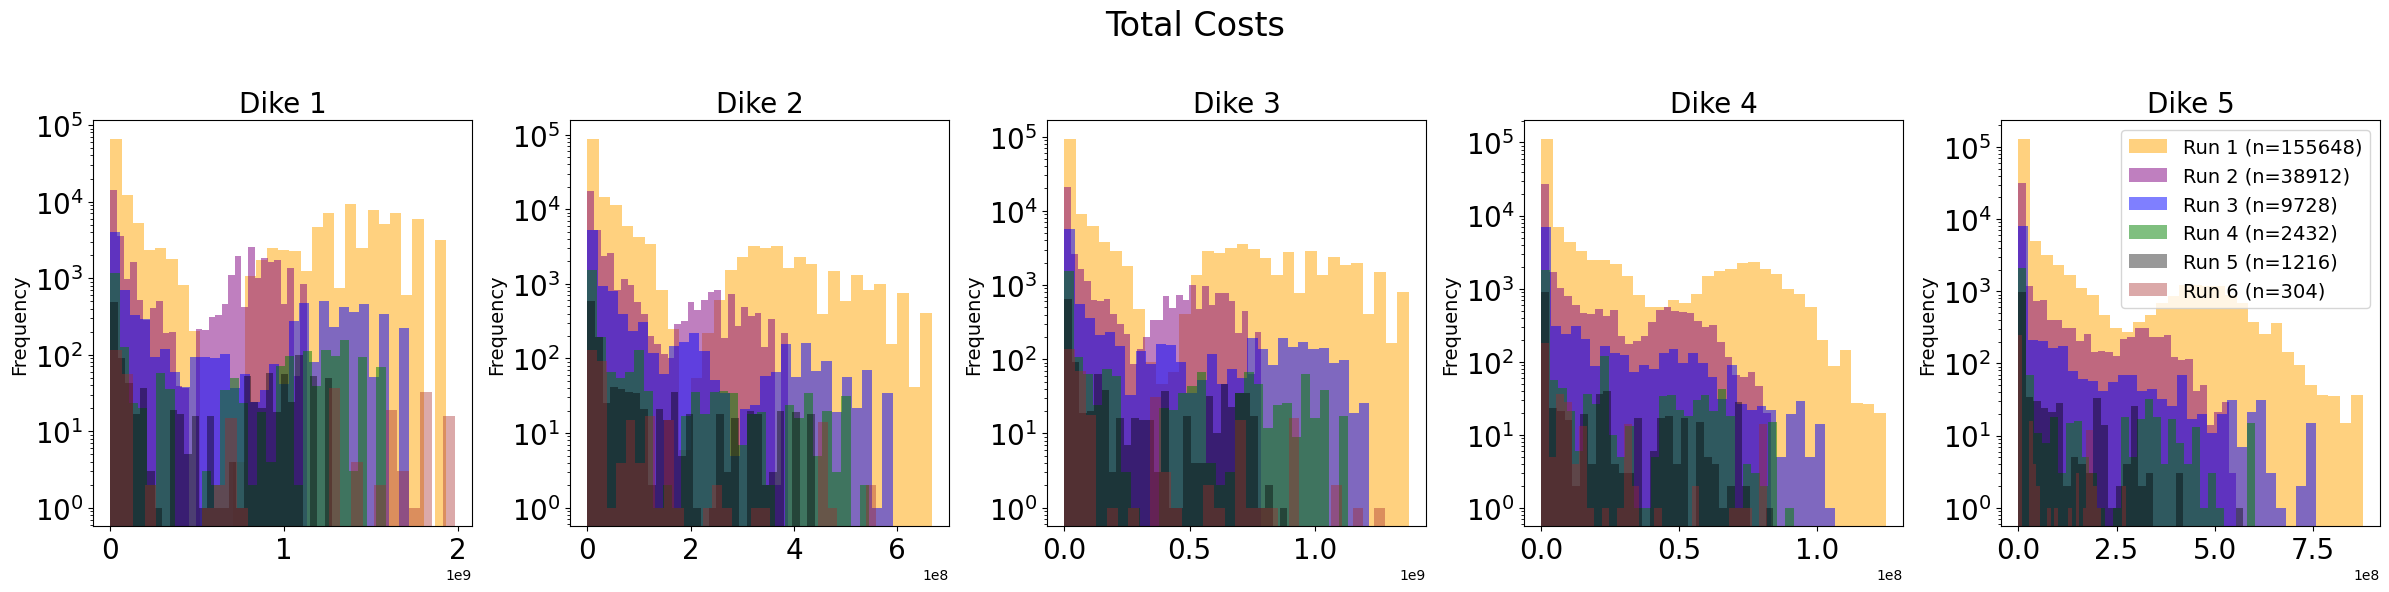

Figure 2: Histograms of disaggregated outcomes for all dikes, comparing 6 runs, in log scale.


In [25]:
## Histogram plot - log scale

disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]

# Plot histograms for each disaggregated outcome for all dikes, comparing two runs
for outcome_name in disaggregated_outcome_names:
    fig, axes = plt.subplots(1, 5, figsize=(24, 6))
    for i, dike_no in enumerate(range(1, 6)):
        key = f"A.{dike_no}_{outcome_name}"
        axes[i].hist(outcomes_1[key], bins=30, color='orange', edgecolor='none', alpha=0.5, label=f'Run 1 (n={experiments_1.shape[0]})')
        axes[i].hist(outcomes_2[key], bins=30, color='purple', edgecolor='none', alpha=0.5, label=f'Run 2 (n={experiments_2.shape[0]})')
        axes[i].hist(outcomes_3[key], bins=30, color='blue', edgecolor='none', alpha=0.5, label=f'Run 3 (n={experiments_3.shape[0]})')
        axes[i].hist(outcomes_4[key], bins=30, color='green', edgecolor='none', alpha=0.5, label=f'Run 4 (n={experiments_4.shape[0]})')
        axes[i].hist(outcomes_5[key], bins=30, color='black', edgecolor='none', alpha=0.4, label=f'Run 5 (n={experiments_5.shape[0]})')
        axes[i].hist(outcomes_6[key], bins=30, color='brown', edgecolor='none', alpha=0.4, label=f'Run 6 (n={experiments_6.shape[0]})')
        axes[i].set_title(f"Dike {dike_no}", fontsize=20)
        axes[i].set_ylabel("Frequency", fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=20)
        axes[i].set_yscale('log')
        if i == 4:
            axes[i].legend(fontsize=14)
    fig.suptitle(f"{outcome_name}", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

print("Figure 2: Histograms of disaggregated outcomes for all dikes, comparing 6 runs, in log scale.")

**Discussion**

We ran the model for 6 times with specifying different number of scenarios. The distribution ...

In [21]:
'''
disaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]
# Plot KDEs for each disaggregated outcome for all dikes, comparing two runs
for outcome_name in disaggregated_outcome_names:
    fig, axes = plt.subplots(1, 5, figsize=(24, 6))

    bw_adjust = 0.7  # Bandwidth adjustment for KDE

    for i, dike_no in enumerate(range(1, 6)):
        key = f"A.{dike_no}_{outcome_name}"
        sns.kdeplot(outcomes_1[key], ax=axes[i], color='orange', label=f'Run 1 (n={experiments_1.shape[0]})', fill=False, alpha=0.5, clip=(0, None), bw_adjust=bw_adjust)
        sns.kdeplot(outcomes_2[key], ax=axes[i], color='purple', label=f'Run 2 (n={experiments_2.shape[0]})', fill=False, alpha=0.5, clip=(0, None), bw_adjust=bw_adjust)
        sns.kdeplot(outcomes_3[key], ax=axes[i], color='blue', label=f'Run 3 (n={experiments_3.shape[0]})', fill=False, alpha=0.5, clip=(0, None), bw_adjust=bw_adjust)
        sns.kdeplot(outcomes_4[key], ax=axes[i], color='green', label=f'Run 4 (n={experiments_4.shape[0]})', fill=False, alpha=0.5, clip=(0, None), bw_adjust=bw_adjust)
        sns.kdeplot(outcomes_5[key], ax=axes[i], color='black', label=f'Run 5 (n={experiments_5.shape[0]})', fill=False, alpha=0.5, clip=(0, None), bw_adjust=bw_adjust)
        sns.kdeplot(outcomes_6[key], ax=axes[i], color='brown', label=f'Run 6 (n={experiments_6.shape[0]})', fill=False, alpha=0.5, clip=(0, None), bw_adjust=bw_adjust)
        axes[i].set_title(f"Dike {dike_no}", fontsize=20)
        axes[i].set_ylabel("Density", fontsize=14)
        axes[i].tick_params(axis='both', which='major', labelsize=20)
        if i == 4:
            axes[i].legend(fontsize=14)
    fig.suptitle(f"{outcome_name}", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    '''


'\ndisaggregated_outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]\n# Plot KDEs for each disaggregated outcome for all dikes, comparing two runs\nfor outcome_name in disaggregated_outcome_names:\n    fig, axes = plt.subplots(1, 5, figsize=(24, 6))\n\n    bw_adjust = 0.7  # Bandwidth adjustment for KDE\n\n    for i, dike_no in enumerate(range(1, 6)):\n        key = f"A.{dike_no}_{outcome_name}"\n        sns.kdeplot(outcomes_1[key], ax=axes[i], color=\'orange\', label=f\'Run 1 (n={experiments_1.shape[0]})\', fill=False, alpha=0.5, clip=(0, None), bw_adjust=bw_adjust)\n        sns.kdeplot(outcomes_2[key], ax=axes[i], color=\'purple\', label=f\'Run 2 (n={experiments_2.shape[0]})\', fill=False, alpha=0.5, clip=(0, None), bw_adjust=bw_adjust)\n        sns.kdeplot(outcomes_3[key], ax=axes[i], color=\'blue\', label=f\'Run 3 (n={experiments_3.shape[0]})\', fill=False, alpha=0.5, clip=(0, None), bw_adjust=bw_adjust)\n        sns.kdeplot(outcomes_4[key], ax=ax

In [13]:
# Compare summary statistics for each outcome and dike (1-5) across all runs (3, 3a, 4, 4a, 5, 6)
runs = [
    ("Run 1", outcomes_1),
    ("Run 2", outcomes_2),
    ("Run 3", outcomes_3),
    ("Run 4", outcomes_4),
    ("Run 5", outcomes_5),
    ("Run 6", outcomes_6),
]

summary_stats = []

for outcome_name in disaggregated_outcome_names:
    for dike_no in range(1, 6):
        key = f"A.{dike_no}_{outcome_name}"
        stats_row = {'Outcome': f"Dike {dike_no} - {outcome_name}"}
        for run_name, outcomes in runs:
            data = outcomes[key]
            stats_row[f'{run_name} Mean'] = np.mean(data)
            stats_row[f'{run_name} Std'] = np.std(data)
            stats_row[f'{run_name} 5th %ile'] = np.percentile(data, 5)
            stats_row[f'{run_name} 50th %ile'] = np.percentile(data, 50)
            stats_row[f'{run_name} 95th %ile'] = np.percentile(data, 95)
        summary_stats.append(stats_row)

summary_df = pd.DataFrame(summary_stats)
pd.set_option('display.float_format', '{:.3g}'.format)
display(summary_df)

,Outcome,Run 1 Mean,Run 1 Std,Run 1 5th %ile,Run 1 50th %ile,Run 1 95th %ile,Run 2 Mean,Run 2 Std,Run 2 5th %ile,Run 2 50th %ile,...,Run 5 Mean,Run 5 Std,Run 5 5th %ile,Run 5 50th %ile,Run 5 95th %ile,Run 6 Mean,Run 6 Std,Run 6 5th %ile,Run 6 50th %ile,Run 6 95th %ile
0,Dike 1 - Expected Annual Damage,6.17e+08,6.91e+08,0,1.26e+08,1.75e+09,3.87e+08,4.1e+08,0,1.3e+08,...,4.28e+08,4.75e+08,0,9.01e+07,1.18e+09,6.64e+08,7.66e+08,0,8.99e+07,1.95e+09
1,Dike 2 - Expected Annual Damage,8.81e+07,1.5e+08,0,1.69e+07,4.39e+08,6.5e+07,9.91e+07,0,1.58e+07,...,6.86e+07,1.11e+08,0,1.95e+07,3.47e+08,6.14e+07,1.16e+08,0,2.37e+07,4.65e+08
2,Dike 3 - Expected Annual Damage,2.32e+08,3.74e+08,0,1.49e+07,1.08e+09,1.56e+08,2.32e+08,0,1.74e+07,...,1.72e+08,2.52e+08,0,1.15e+07,7.11e+08,1.74e+08,2.87e+08,0,4.64e+07,9.09e+08
3,Dike 4 - Expected Annual Damage,1.15e+07,2.44e+07,0,0,7.69e+07,8.78e+06,1.75e+07,0,0,...,8.42e+06,1.78e+07,0,0,5.29e+07,9.44e+06,1.95e+07,0,0,7.12e+07
4,Dike 5 - Expected Annual Damage,4.22e+07,1.24e+08,0,0,4.1e+08,3.3e+07,8.9e+07,0,0,...,2.77e+07,7.12e+07,0,0,2.05e+08,2.37e+07,5.88e+07,0,0,1.9e+08
5,Dike 1 - Expected Number of Deaths,0.538,0.589,0,0.109,1.32,0.341,0.354,0,0.118,...,0.372,0.4,0,0.0776,0.889,0.556,0.622,0,0.0932,1.35
6,Dike 2 - Expected Number of Deaths,0.102,0.168,0,0.023,0.523,0.0759,0.112,0,0.0199,...,0.0786,0.119,0,0.0266,0.39,0.0729,0.138,0,0.0349,0.578
7,Dike 3 - Expected Number of Deaths,0.517,0.817,0,0.0324,2.38,0.352,0.515,0,0.0411,...,0.394,0.57,0,0.0235,1.57,0.419,0.683,0,0.116,2.34
8,Dike 4 - Expected Number of Deaths,0.0066,0.0138,0,0,0.0453,0.00511,0.0101,0,0,...,0.00483,0.01,0,0,0.0318,0.00567,0.0117,0,0,0.0431
9,Dike 5 - Expected Number of Deaths,0.0482,0.141,0,0,0.483,0.0378,0.101,0,0,...,0.0307,0.0789,0,0,0.238,0.0243,0.0602,0,0,0.209


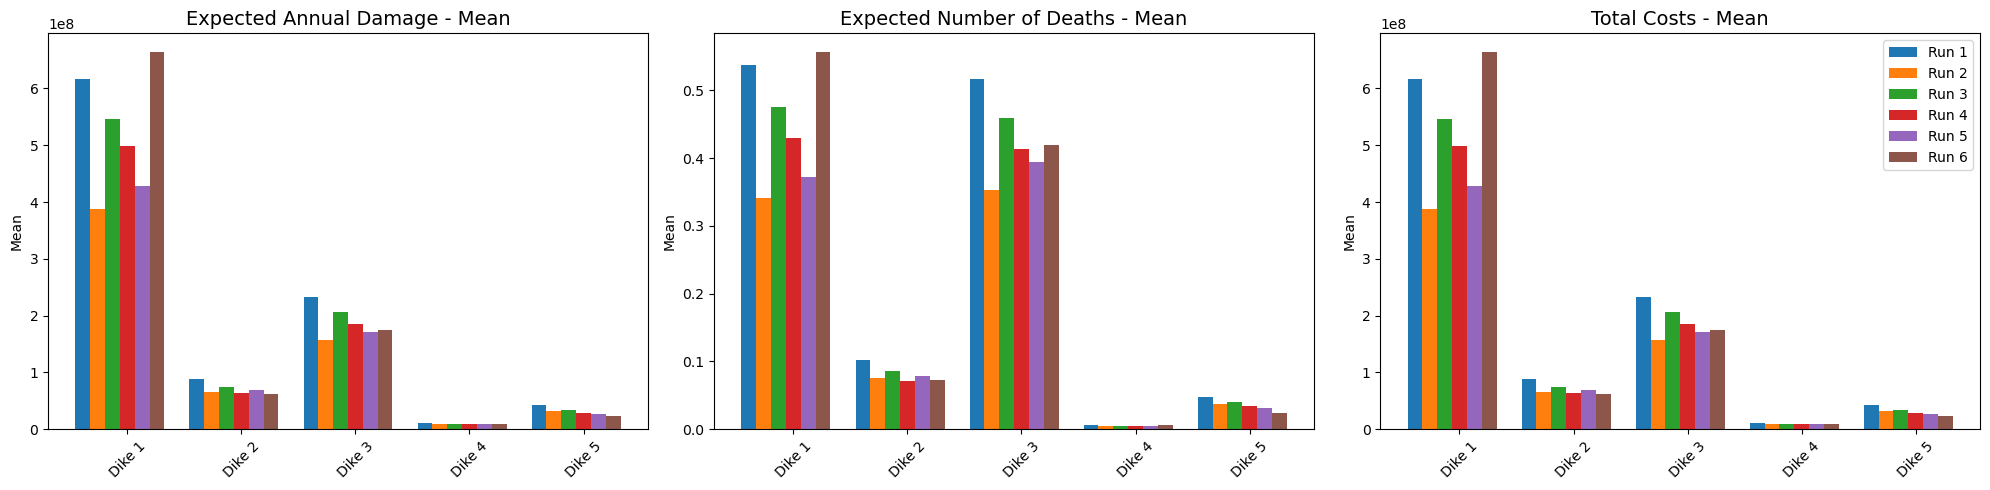

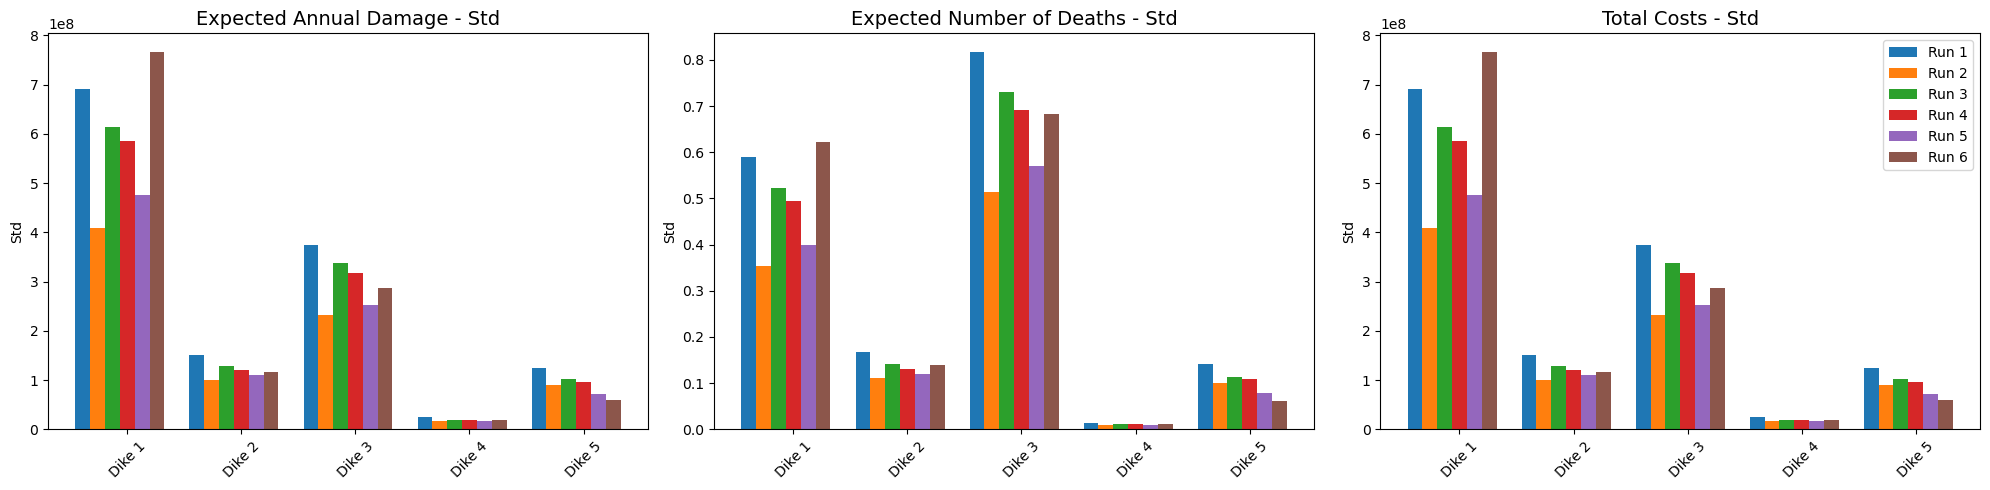

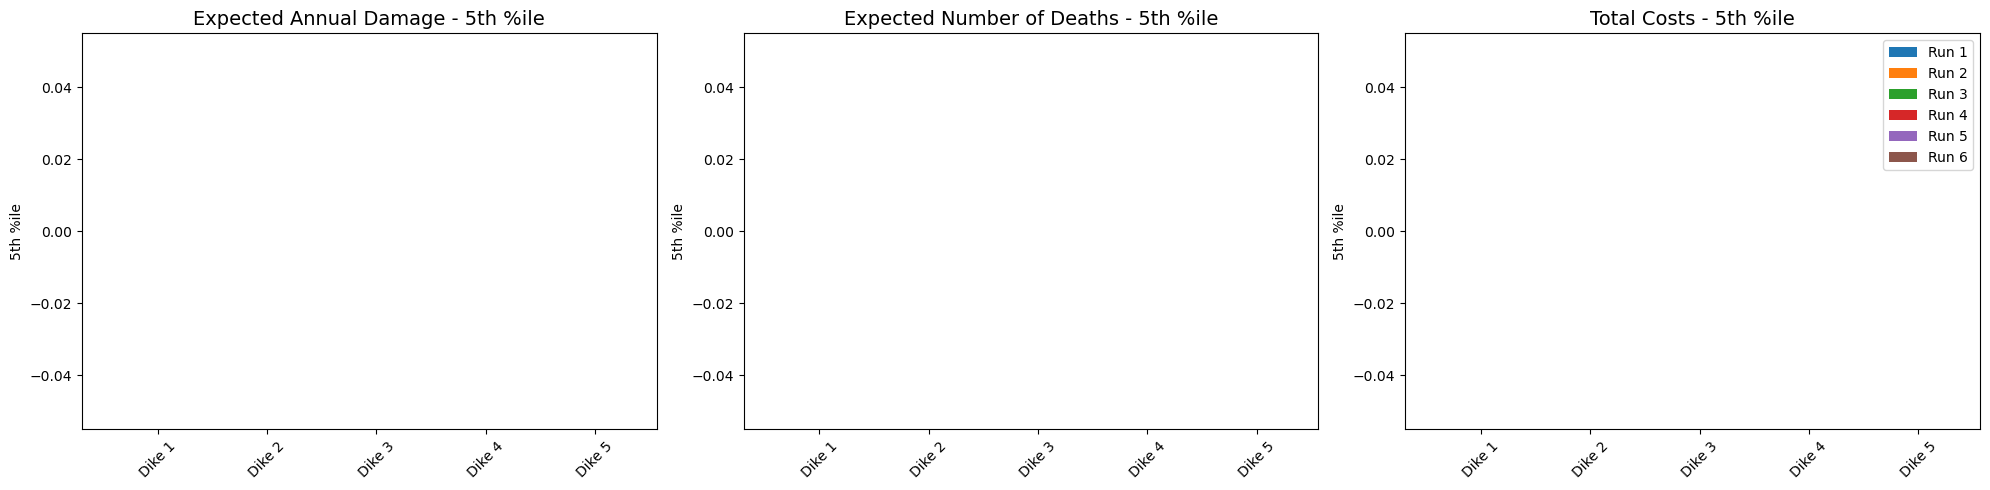

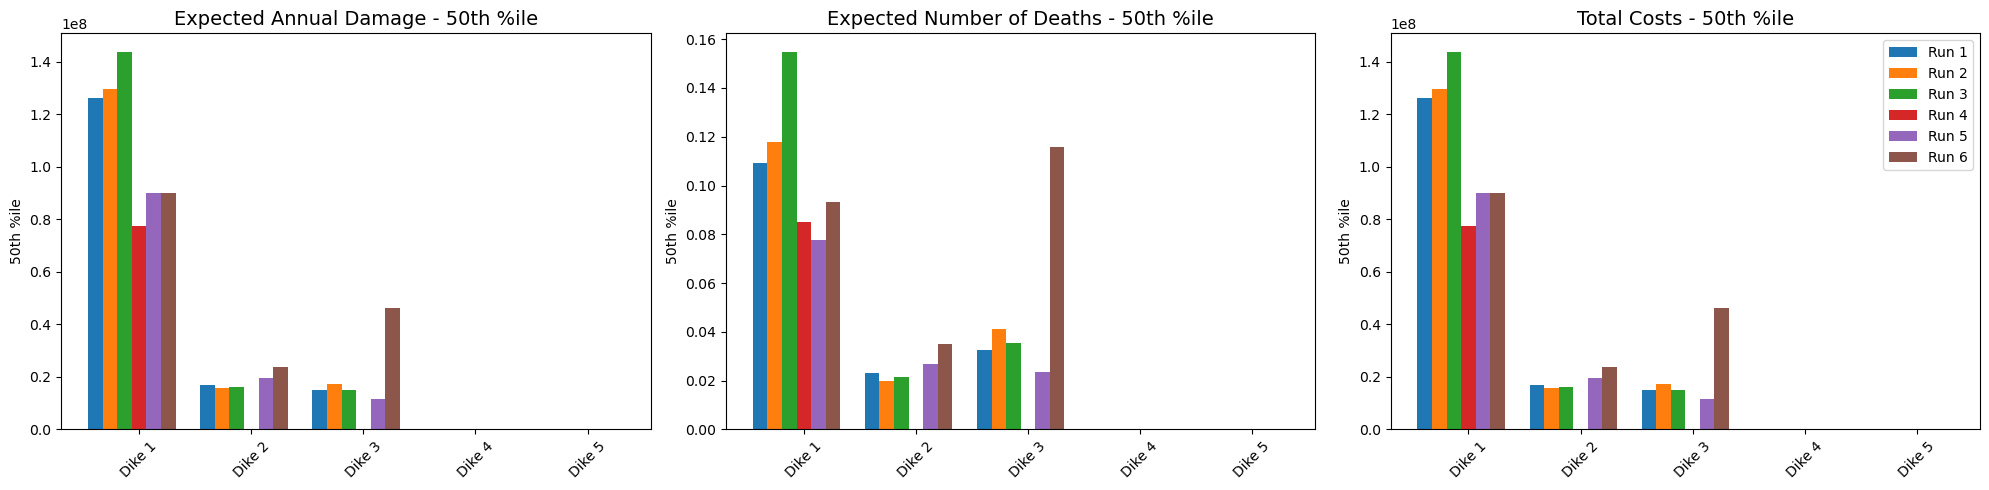

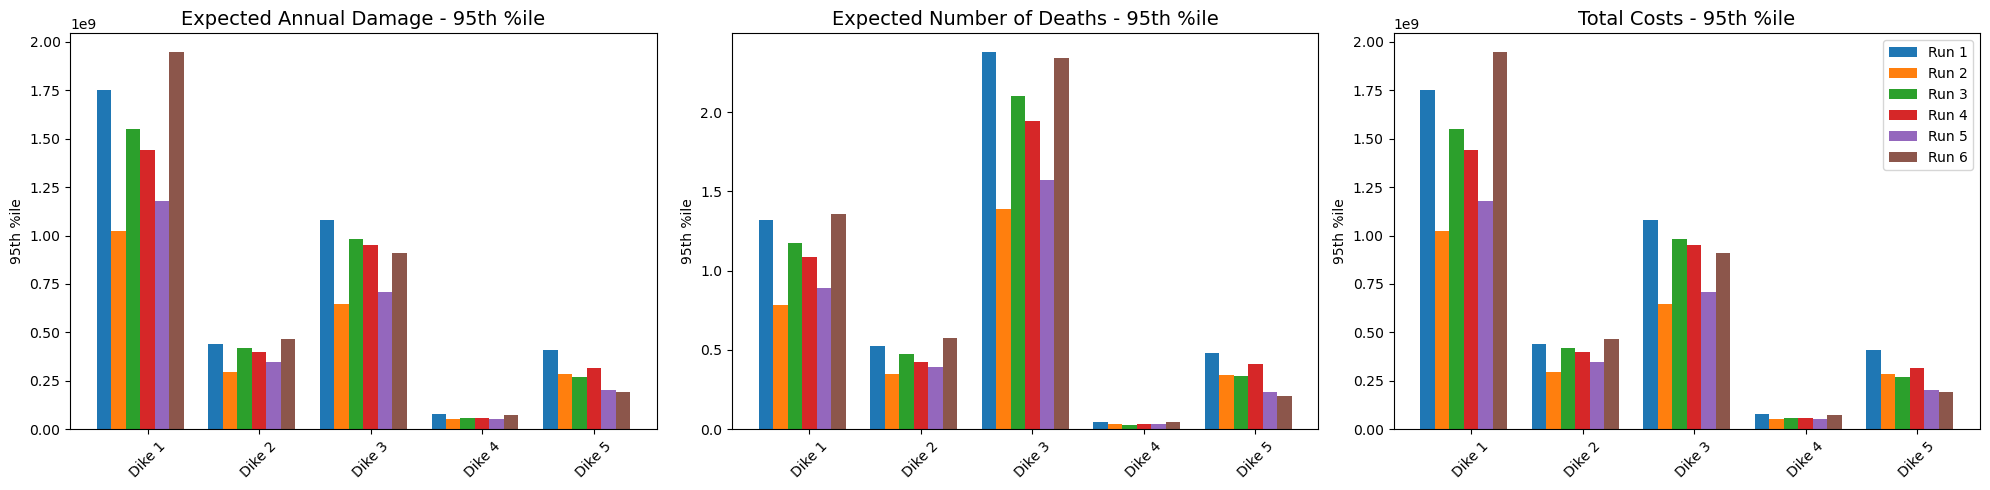

In [ ]:
# Plot each statistic (mean, median, std, 5th, 95th) for each dike as a grouped bar chart across runs

stats_to_plot = [
    ("Mean", "Mean"),
    ("Std", "Std"),
    ("5th %ile", "5th %ile"),
    ("50th %ile", "50th %ile"),
    ("95th %ile", "95th %ile"),
]

run_labels = [f"Run {i}" for i in range(1, 7)]
dike_labels = [f"Dike {i}" for i in range(1, 6)]
outcome_types = ["Expected Annual Damage", "Expected Number of Deaths", "Total Costs"]

for stat_label, stat_col in stats_to_plot:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=False)
    for idx, outcome_type in enumerate(outcome_types):
        mask = summary_df["Outcome"].str.contains(outcome_type)
        df_stat = summary_df[mask]
        # Collect values for each run and dike
        bar_vals = []
        for run in run_labels:
            vals = [df_stat.iloc[d][f"{run} {stat_col}"] for d in range(len(dike_labels))]
            bar_vals.append(vals)
        bar_vals = np.array(bar_vals)  # shape: (n_runs, n_dikes)
        x = np.arange(len(dike_labels))
        width = 0.13
        for i, run in enumerate(run_labels):
            axes[idx].bar(x + i*width - (width*len(run_labels)/2), bar_vals[i], width, label=run)
        axes[idx].set_title(f"{outcome_type} - {stat_label}", fontsize=14)
        axes[idx].set_ylabel(stat_label)
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(dike_labels, rotation=45)
        if idx == 2:
            axes[idx].legend()
    plt.tight_layout()
    plt.show()

### Compare summary statistics

* Compute and compare means, medians, standard deviations, and percentiles (e.g., 5th, 50th, 95th) for each outcome.
* Small differences between runs indicate stability.

In [22]:
# Compare summary statistics for each outcome and dike (1-5)
summary_stats = []

for outcome_name in disaggregated_outcome_names:
    for dike_no in range(1, 6):
        key = f"A.{dike_no}_{outcome_name}"
        data1 = outcomes_3[key]
        data2 = outcomes_3a[key]
        stats = {
            'Outcome': f"Dike {dike_no} - {outcome_name}",
            'Run 1 Mean': np.mean(data1),
            'Run 2 Mean': np.mean(data2),
            'Mean Diff %': 100 * (np.mean(data2) - np.mean(data1)) / np.mean(data1) if np.mean(data1) != 0 else np.nan,
            'Run 1 Median': np.median(data1),
            'Run 2 Median': np.median(data2),
            'Median Diff %': 100 * (np.median(data2) - np.median(data1)) / np.median(data1) if np.median(data1) != 0 else np.nan,
            'Run 1 Std': np.std(data1),
            'Run 2 Std': np.std(data2),
            'Std Diff %': 100 * (np.std(data2) - np.std(data1)) / np.std(data1) if np.std(data1) != 0 else np.nan,
            'Run 1 5th %ile': np.percentile(data1, 5),
            'Run 2 5th %ile': np.percentile(data2, 5),
            '5th %ile Diff %': 100 * (np.percentile(data2, 5) - np.percentile(data1, 5)) / np.percentile(data1, 5) if np.percentile(data1, 5) != 0 else np.nan,
            'Run 1 95th %ile': np.percentile(data1, 95),
            'Run 2 95th %ile': np.percentile(data2, 95),
            '95th %ile Diff %': 100 * (np.percentile(data2, 95) - np.percentile(data1, 95)) / np.percentile(data1, 95) if np.percentile(data1, 95) != 0 else np.nan,
        }
        summary_stats.append(stats)

summary_df = pd.DataFrame(summary_stats)
pd.set_option('display.float_format', '{:.3g}'.format)
display(summary_df)

,Outcome,Run 1 Mean,Run 2 Mean,Mean Diff %,Run 1 Median,Run 2 Median,Median Diff %,Run 1 Std,Run 2 Std,Std Diff %,Run 1 5th %ile,Run 2 5th %ile,5th %ile Diff %,Run 1 95th %ile,Run 2 95th %ile,95th %ile Diff %
0,Dike 1 - Expected Annual Damage,5.45e+08,5.45e+08,0,1.44e+08,1.44e+08,0,6.14e+08,6.14e+08,0,0,0,NaN,1.55e+09,1.55e+09,0
1,Dike 2 - Expected Annual Damage,7.51e+07,7.51e+07,0,1.6e+07,1.6e+07,0,1.29e+08,1.29e+08,0,0,0,NaN,4.2e+08,4.2e+08,0
2,Dike 3 - Expected Annual Damage,2.07e+08,2.07e+08,0,1.49e+07,1.49e+07,0,3.37e+08,3.37e+08,0,0,0,NaN,9.82e+08,9.82e+08,0
3,Dike 4 - Expected Annual Damage,9.35e+06,9.35e+06,0,0,0,NaN,1.91e+07,1.91e+07,0,0,0,NaN,5.57e+07,5.57e+07,0
4,Dike 5 - Expected Annual Damage,3.47e+07,3.47e+07,0,0,0,NaN,1.02e+08,1.02e+08,0,0,0,NaN,2.67e+08,2.67e+08,0
5,Dike 1 - Expected Number of Deaths,0.475,0.475,0,0.155,0.155,0,0.523,0.523,0,0,0,NaN,1.18,1.18,0
6,Dike 2 - Expected Number of Deaths,0.0862,0.0862,0,0.0214,0.0214,0,0.142,0.142,0,0,0,NaN,0.474,0.474,0
7,Dike 3 - Expected Number of Deaths,0.46,0.46,0,0.0355,0.0355,0,0.732,0.732,0,0,0,NaN,2.1,2.1,0
8,Dike 4 - Expected Number of Deaths,0.0053,0.0053,0,0,0,NaN,0.0106,0.0106,0,0,0,NaN,0.0293,0.0293,0
9,Dike 5 - Expected Number of Deaths,0.0396,0.0396,0,0,0,NaN,0.113,0.113,0,0,0,NaN,0.337,0.337,0


### Convergence Plots

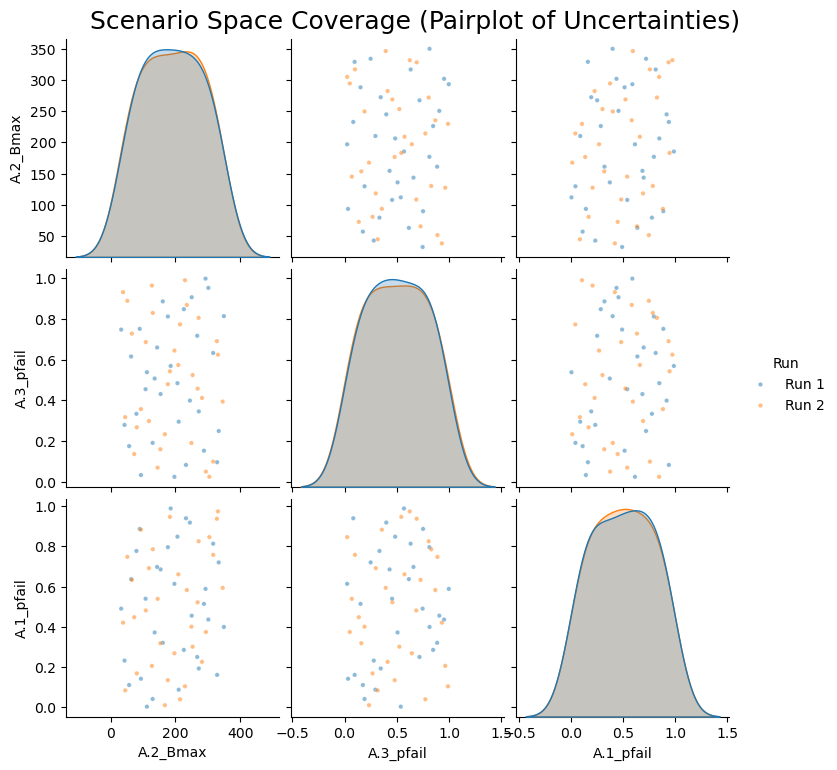

In [60]:
# Visualize scenario space coverage for both runs using pairplot (if uncertainties are not too many)
uncertainty_names = [u.name for u in uncertainties]
max_uncertainties_for_pairplot = 6  # Limit for reasonable pairplot visualization

# Randomly select 6 uncertainties for visualization
np.random.seed(0)
selected_uncertainties = np.random.choice(uncertainty_names, size=6, replace=False).tolist()

if len(selected_uncertainties) <= max_uncertainties_for_pairplot:
    # Prepare dataframes for both runs
    df1 = results_1[0][selected_uncertainties].copy()
    df1['Run'] = 'Run 1'
    df2 = results_2[0][selected_uncertainties].copy()
    df2['Run'] = 'Run 2'
    combined_df = pd.concat([df1, df2], ignore_index=True)

    # Pairplot
    sns.pairplot(combined_df, hue='Run', plot_kws={'alpha': 0.5, 's': 10})
    plt.suptitle("Scenario Space Coverage (Pairplot of Uncertainties)", y=1.02, fontsize=18)
    plt.show()
else:
    print(f"Too many uncertainties ({len(selected_uncertainties)}) for a pairplot. Consider plotting selected pairs or using dimensionality reduction.")

In [49]:
uncertainty_names

['discount rate 0',
 'discount rate 1',
 'A.0_ID flood wave shape',
 'A.1_Bmax',
 'A.1_pfail',
 'A.1_Brate',
 'A.2_Bmax',
 'A.2_pfail',
 'A.2_Brate',
 'A.3_Bmax',
 'A.3_pfail',
 'A.3_Brate',
 'A.4_Bmax',
 'A.4_pfail',
 'A.4_Brate',
 'A.5_Bmax',
 'A.5_pfail',
 'A.5_Brate']

## 2 Sensitivity Analysis

Sensitivity analysis helps us understand which uncertainties have the greatest impact on model outcomes. By systematically varying uncertain parameters and observing changes in key results, we can identify the most influential factors driving system behavior. This insight guides decision makers in prioritizing data collection, refining models, and focusing policy interventions on the most critical sources of uncertainty. In this section, we will use global sensitivity analysis techniques (such as Sobol indices) to quantify the contribution of each uncertainty to the variance in important outcomes.

## 3 Scenario Discovery

Scenario discovery is a process used to identify and characterize regions of the uncertainty space that are associated with particularly challenging or interesting outcomes. By systematically analyzing simulation results, we can uncover combinations of uncertain factors that lead to policy-relevant cases—such as system failures, high costs, or unacceptable risks. This enables decision makers to focus their attention and resources on the most critical scenarios, supporting robust policy design and targeted risk management. In this section, we will apply scenario discovery techniques (such as Patient Rule Induction Method, PRIM) to highlight and interpret these key regions of interest within the broader set of simulated futures.